In [1]:
import pandas as pd
from Functions import Metrics
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
df = pd.read_csv('train_clean.csv')
df.head(3)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,geo_cod
0,0,15674932,Okwudilichukwu,668,France,1,33.0,3,0.0,2,1.0,0.0,181449.97,0,0
1,1,15749177,Okwudiliolisa,627,France,1,33.0,1,0.0,2,1.0,1.0,49503.50,0,0
2,2,15694510,Hsueh,678,France,1,40.0,10,0.0,2,1.0,0.0,184866.69,0,0


## Modelado

### Feature Engineering

In [3]:
#NUMERO DE OBSERVACIONES QUE SE FUEROND EL BANCO
n_exited = df.loc[df.Exited == 1].shape[0]

#DATAFRAME COMPLEMENTARIO CON MUESTRAS DE AQUELLAS QUE NO
df_sample = df.loc[df.Exited == 0].sample(n=n_exited*2, random_state=15)

#UNION DE REGISTROS
df_sample = pd.concat([df_sample,
                       df.loc[df.Exited == 1]],
                       axis=0)

df_sample = df_sample.reset_index(drop=True)
print(f'Filas y columnas: {df_sample.shape}')


Filas y columnas: (104763, 15)


In [4]:
#NORMALIZACION
from sklearn.preprocessing import StandardScaler

#LISTA DE VARIABLES A NORMALIZAR
vars = ['Age','Balance']#'CreditScore',

#INSTANCIA DEL MODELO Y TRANSOFRMACION
std_vars = StandardScaler().fit_transform(df_sample[vars])

#SE CREA DATAFRAME COMPLEMETARIO
std_vars = pd.DataFrame(std_vars, columns=vars)
std_vars.head(3)

,Age,Balance
0,-1.411057,-0.918044
1,0.589415,-0.918044
2,0.089297,1.524931


In [5]:
#SELECCION DE VARIABLES
#vars = ['NumOfProducts','HasCrCard','IsActiveMember','geo_cod']
vars = ['NumOfProducts','IsActiveMember','Gender','geo_cod']
#VARIABLES PREDICTIVAS
x = pd.concat([df_sample[vars],
                std_vars], axis=1)

#VARIABLE OBJETIVO
y = df_sample.Exited

In [6]:
#IMPORTACION DE LIBRERIA
from sklearn.model_selection import train_test_split

#DIVISION DE DATOS PARA TRAIN Y TEST
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=42)

### KNN - Entrenamiento y validacion simple del modelo

In [7]:
from sklearn.neighbors import KNeighborsClassifier


#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = KNeighborsClassifier(n_neighbors=35)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test ,y_pred=y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8209


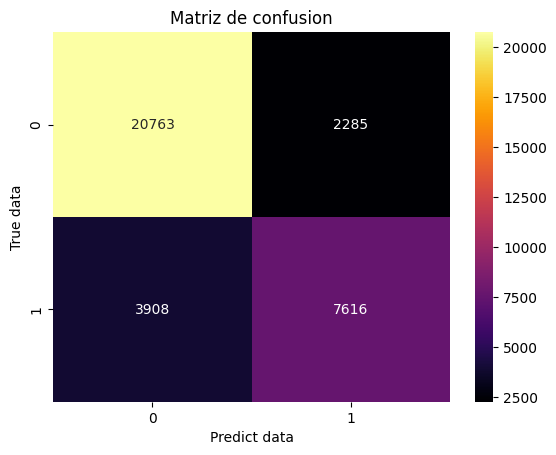

In [8]:
#GRAFICO MATRIZ DE CONFUSION
Metrics().plot_confusion_matrix_dicotomic(y_test, y_pred, None, None)

In [9]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.8783


### Random Forest - Entrenamiento y validacion simple del modelo

In [10]:
from sklearn.ensemble import RandomForestClassifier

#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = RandomForestClassifier(max_depth=20, n_estimators=300, criterion='entropy',random_state=42)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test ,y_pred=y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8005


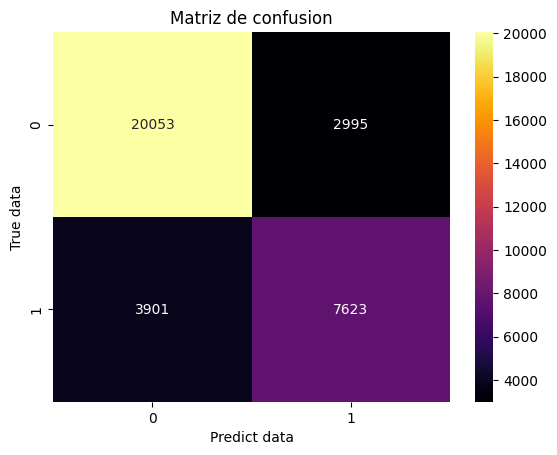

In [11]:
#GRAFICO DE MATRIZ DE CONFUSION
Metrics().plot_confusion_matrix_dicotomic(y_test, y_pred, None, None)

In [12]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.8597


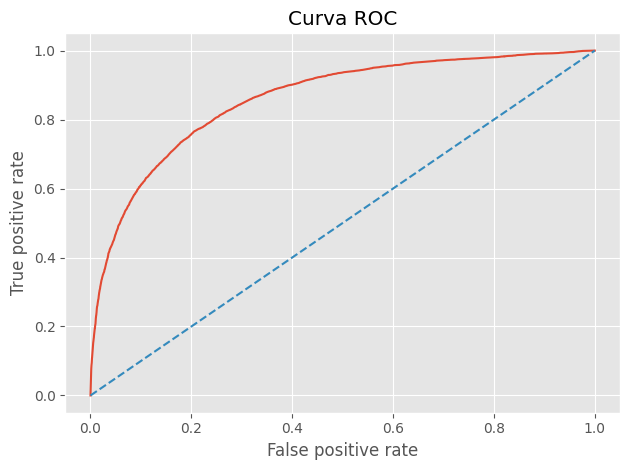

In [13]:
#PLOT CURVE ROC
Metrics().plot_roc_curve(y_test, y_prob)

### XG-Boost - Entrenamiento y validacion simple del modelo

In [14]:
#IMPOTRACION DE MODELO PARA TEST DE PARAMETROS
from sklearn.model_selection import GridSearchCV

#GRILLA DE PARAMETROS PARA TESTEAR
param_grid = {
    'objective' :['binary:logistic'],
    'max_depth': [10, 15],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [9, 15],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0.1, 0.2],
    'random_state': [47]
}

In [15]:
#IMPORTACION MODELO DE BOOOSTING
from xgboost import XGBClassifier

#SE ENTRENA MODELO UTILIZANDO GRIDSEARCH
#model = GridSearchCV(estimator=XGBClassifier(),
#                     param_grid=param_grid,
#                     cv=3, n_jobs=-1,
#                     scoring='accuracy')


model = XGBClassifier( objective = 'binary:logistic',
                       max_depth = 10,
                       learning_rate = 0.2,
                       n_estimators = 15,
                       subsample = 0.9,
                       colsample_bytree = 0.8,
                       gamma = 0.2,
                       random_state = 47)

#ENTRENAMIENTO
model.fit(X_train,y_train)

#PREDICCION
y_pred = model.predict(X_test)

#SCORE
accuracy_score(y_true=y_test, y_pred=y_pred)

0.8220525280573875

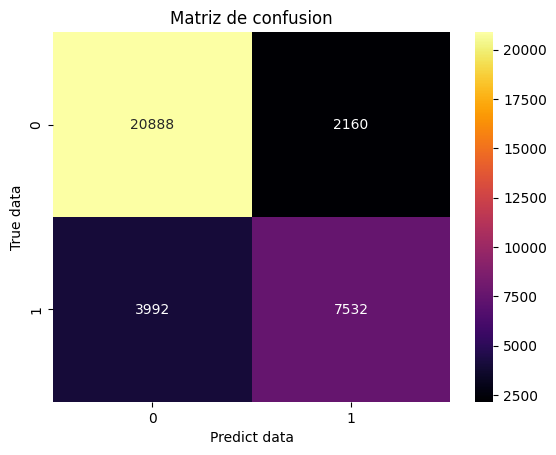

In [16]:
Metrics().plot_confusion_matrix_dicotomic(y_test, y_pred, None, None)

In [17]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.8841


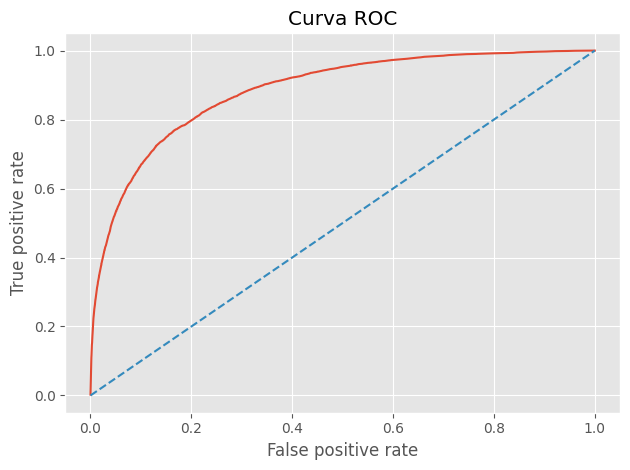

In [18]:
#PLOT CURVE ROC
Metrics().plot_roc_curve(y_test, y_prob)

model = GridSearchCV(DecisionTreeClassifier(),
                     param_grid=param_grid,
                     cv=3,
                     n_jobs=-1,
                     scoring='accuracy')

model.fit(X_train, y_train)

print(f'Mejor puntaje de validacion cruzada(en entrenamiento): {model.best_score_}')
print('\nMejores parametros:')
for key, value in model.best_params_.items():
    print(f'\t{key}: {value}')